# Pré-processamento de dados

Neste arquivo será realizado o pré-processamento de dados, bem como filtros temporais, espaciais e visualização de dados em gráficos.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
import mne
from copy import deepcopy as dc

In [2]:
# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=256, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=256, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=256, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=256, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    print(low, high)
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data, padlen=7)

### Visualização dos gráficos com e sem filtros

... explicação (**tarefa** completar a explicação).

In [3]:
def print_graphs(X):
    for i in range(X.shape[1]):
        plt.plot(X[:,i])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(X.shape[1]):
        plt.psd(X[:,i], Fs=250)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(X.shape[1]):
        plt.specgram(X[i,:], Fs=250)
    plt.title('Espectrograma')
    plt.show()

(564184, 8)


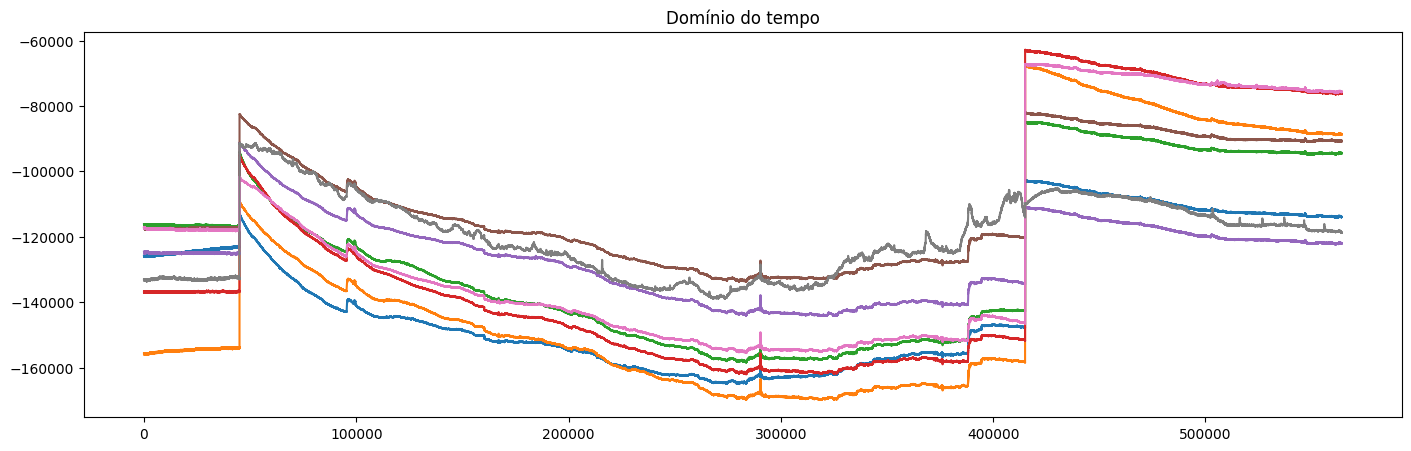

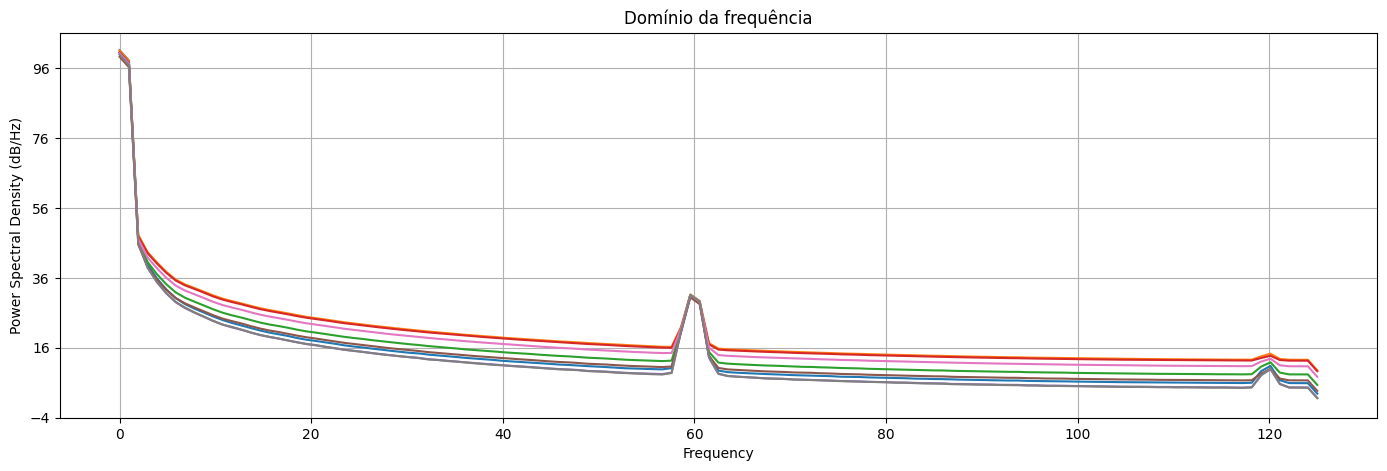

/tmp/ipykernel_2724/291471394.py:13: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=8).
  plt.specgram(X[i,:], Fs=250)


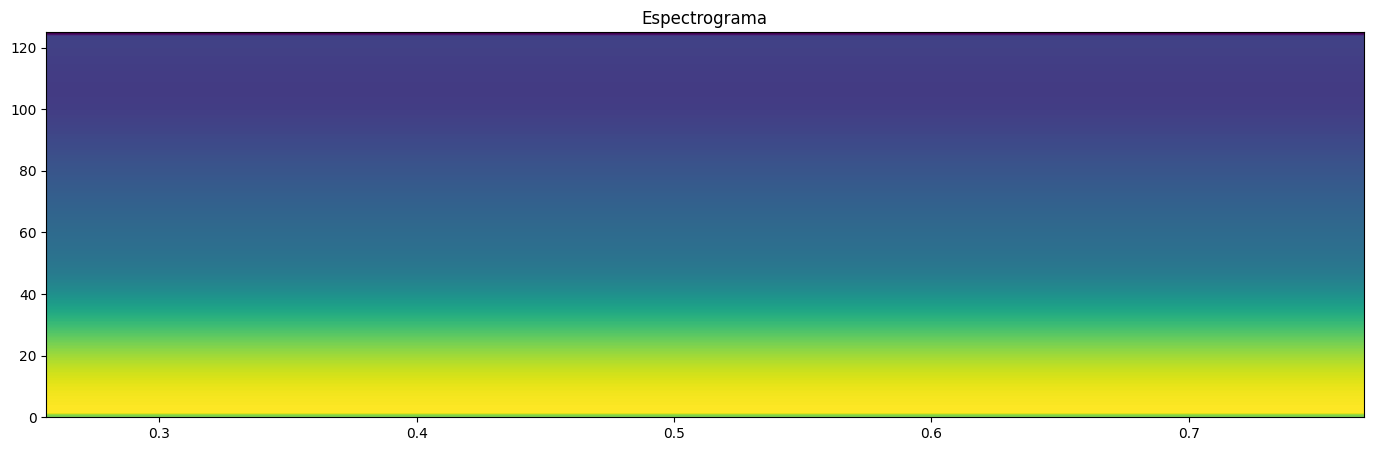

In [4]:
# Apresentação dos dados sem aplicação dos filtros.

data = np.load('../data.npy')
print(data.shape)

rcParams['figure.figsize'] = [17., 5.]
print_graphs(data)

### Aplicação do filtro Notch

Removendo principalmente dados de interferência da rede elétrica.

0.3828125 0.3984375


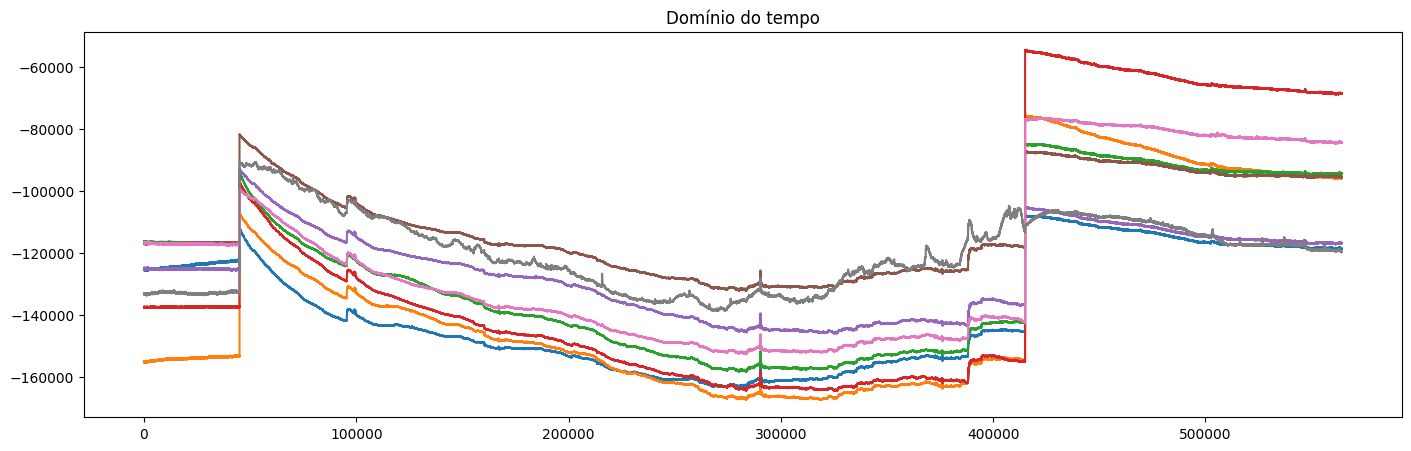

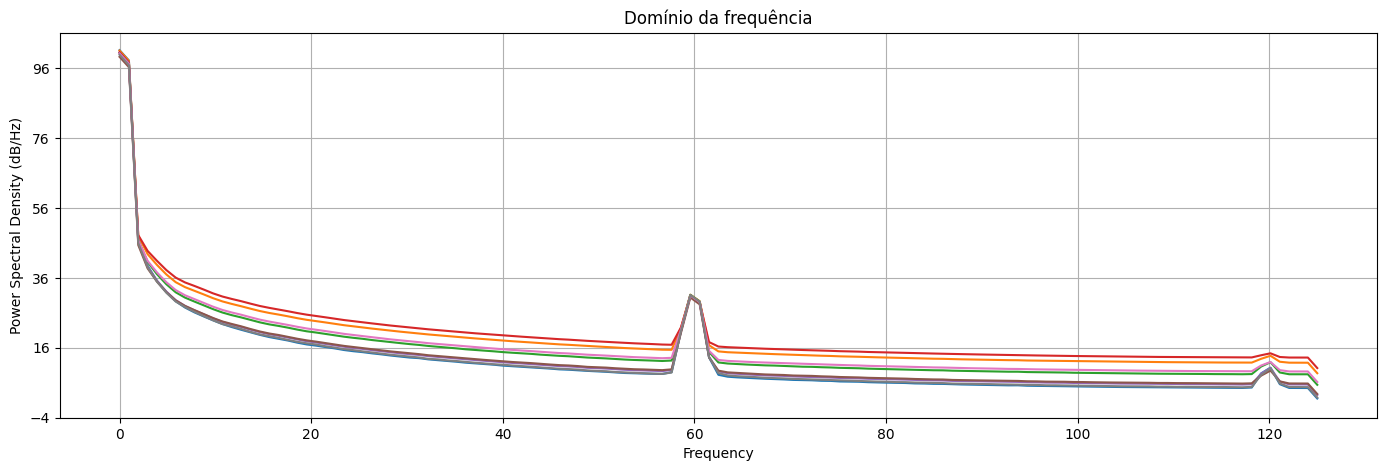

/tmp/ipykernel_2724/291471394.py:13: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=8).
  plt.specgram(X[i,:], Fs=250)


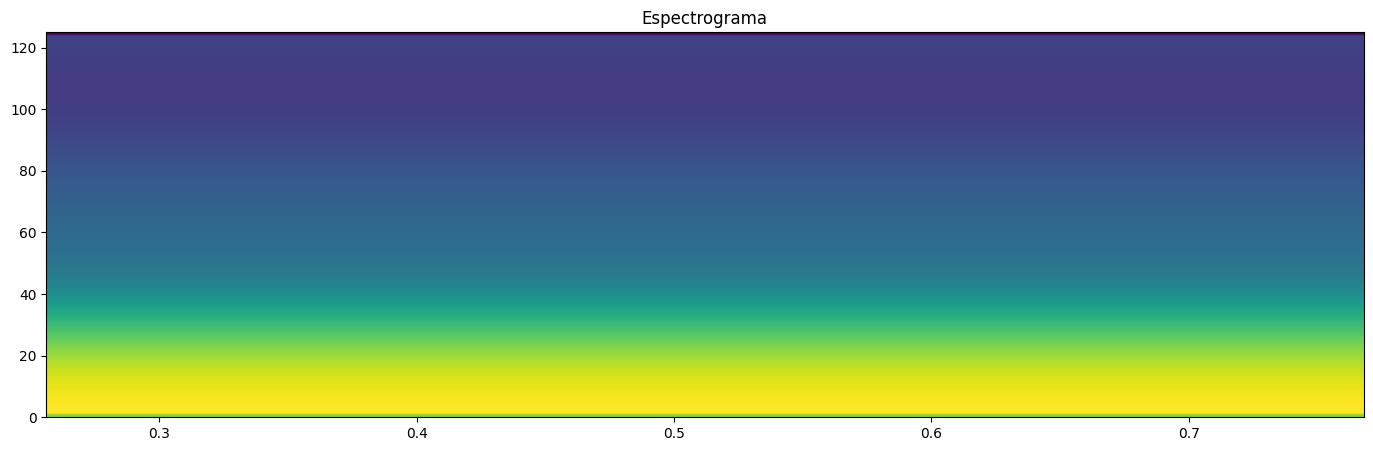

In [6]:
data_filtered = dc(data)
data_filtered = butter_notch(data_filtered, 50)
# data_filtered = data_filtered.reshape(int(data_filtered.shape[0] / 8), 8)
print_graphs(data_filtered)

**Tarefa**: Executem a mesma tarefa com os outros filtros, ajustando o tempos menores (10, 20 segundos...) para visualizar melhor os dados no domínio da frequência e as suas diferenças.

In [7]:
# teste com o objeto MNE

n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["Fp1", "Fp2", "F3", "F4", "T7", "T8", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")
mne_data = mne.io.RawArray(data.T, info)
mne_data

Creating RawArray with float64 data, n_channels=8, n_times=564184
    Range : 0 ... 564183 =      0.000 ...  2256.732 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


Effective window size : 8.192 (s)


/home/pedro/.local/lib/python3.10/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


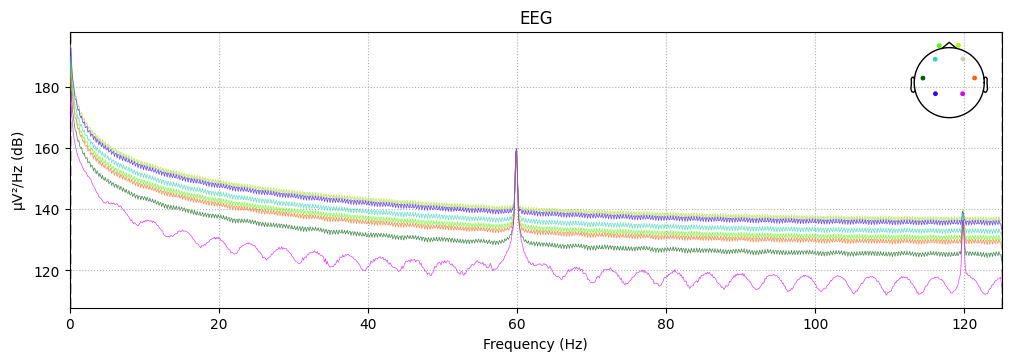

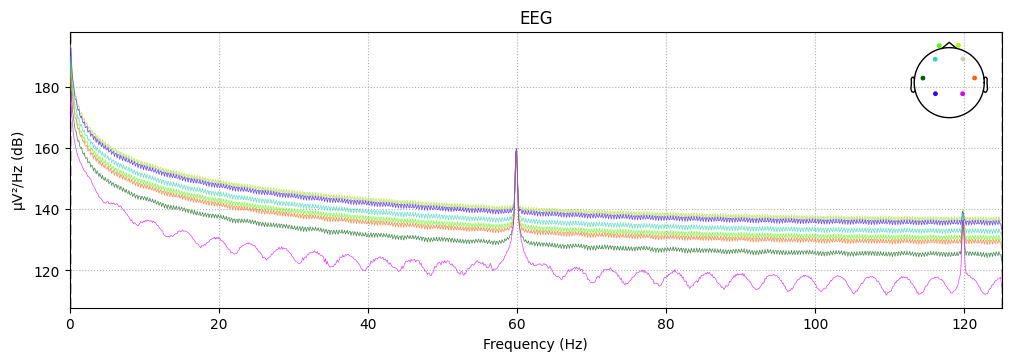

In [8]:
mne_data.compute_psd().plot()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)


- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)

Effective window size : 8.192 (s)


/home/pedro/.local/lib/python3.10/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


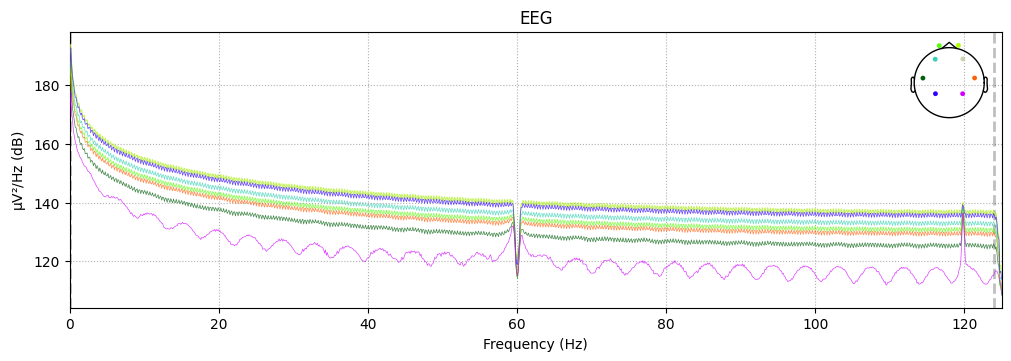

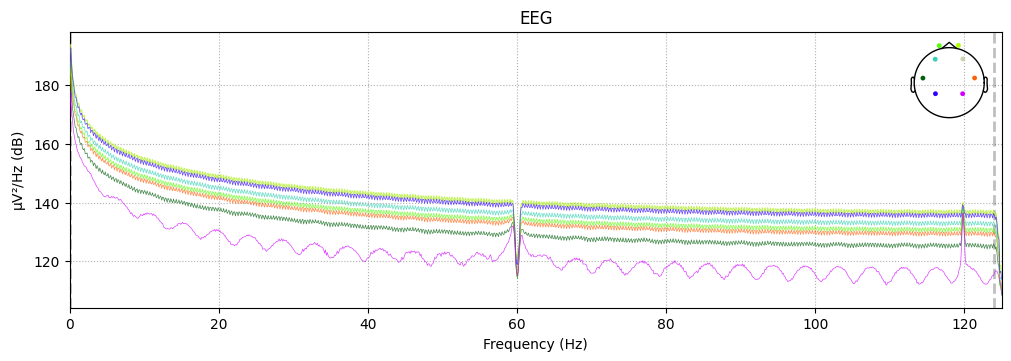

In [9]:
mne_data_filtered = mne_data.copy()
mne_data_filtered = mne_data_filtered.notch_filter(freqs=60)
mne_data_filtered = mne_data_filtered.filter(l_freq=0, h_freq=124)
mne_data_filtered.compute_psd().plot()

In [10]:
mne_data_filtered.save('../data_filtered.fif', overwrite=True)

Writing /home/pedro/Documentos/reconhecimento/OPT020/src/../data_filtered.fif


/tmp/ipykernel_2724/2816160230.py:1: RuntimeWarning: This filename (/home/pedro/Documentos/reconhecimento/OPT020/src/../data_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data_filtered.save('../data_filtered.fif', overwrite=True)


Closing /home/pedro/Documentos/reconhecimento/OPT020/src/../data_filtered.fif
[done]


**Tarefa 1**: Existem parâmetros e métodos no objeto MNE, que permitem obtem janelas específicas de tempo. Utilize destas ferramentas para capturar pedaços específicos do sinal no domínio do tempo que possa ter a evocação do ritmo Beta (Utilizar o OpenBCI GUI para analisar as fatias de tempo).

**Tarefa 2**: Trabalhar em cima dos dados no domínio da frequência! Observar (para a janela de dados que possui ritmo Beta evocado por exemplo) os valores absolutos de energia (PSD). Analisar se realmente os valores que compreendem o ritmo beta está acima dos outros valores, etc. Reportar as conclusões obtidas.